In [222]:
%matplotlib inline
DEFAULT_FIGSIZE = (16, 12)

import pickle
import itertools
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon': True})
import pandas as pd

sys.path.append('..')
from antlia import lidar
from antlia import util
from antlia import plot_braking as braking
from antlia import dtc
from antlia.plotdf import plotjoint

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = DEFAULT_FIGSIZE
mpl.rcParams['legend.facecolor'] = 'white'

colors = sns.color_palette('Paired', 10)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
rid = 3 # rider id
tid = 12 # trial id

# load records without syncing
records = lidar.load_records(sync=True, index=3)[0]

trial = record.trial[tid]

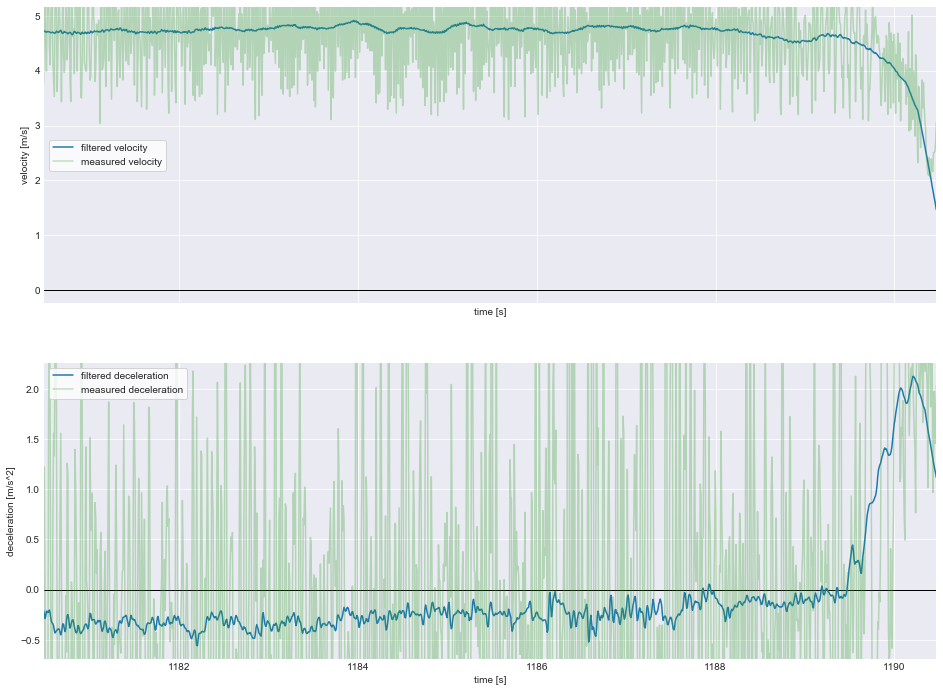

In [213]:
plt.close('all')
fig, axes = plt.subplots(2, 1, sharex=True)
braking.plot_trial_braking_event(trial.data, ax=axes[0])
braking.plot_trial_braking_event(trial.data, ax=axes[1])

# remove braking region
for i, ax in enumerate(axes):
    [child.remove() for child in ax.get_children()
     if isinstance(child, mpatches.Polygon)]

    lines = ax.get_lines()
    
    # remove best fit line
    lines[5].remove()
    
    if i == 0:
        ax.set_ylabel('velocity [m/s]')

        # remove acceleration
        lines[1].remove()
        lines[3].remove()
        
        filtered = lines[0]
        measured = lines[2]
        
        # update label
        filtered.set_label('filtered velocity')
        measured.set_label('measured velocity')
    else:
        ax.set_ylabel('deceleration [m/s^2]')
        
        # remove velocity
        lines[0].remove()
        lines[2].remove()
        
        filtered = lines[1]
        measured = lines[3]
        
        # update label
        filtered.set_label('filtered deceleration')
        measured.set_label('measured deceleration')
        
    # store y data for measured signal
    y = measured.get_ydata()
    
    # relimit based on filtered signal
    measured.set_ydata(0*y)
    ax.relim()
    ax.autoscale()
    
    # restore measured signal
    measured.set_ydata(y)
    
    filtered.set_color(colors[1])
    measured.set_color(colors[3])
        
    ax.legend()
    
# change x limits
t = ax.get_lines()[0].get_xdata()
ax.set_xlim((t[0], t[-1]))

plt.show()

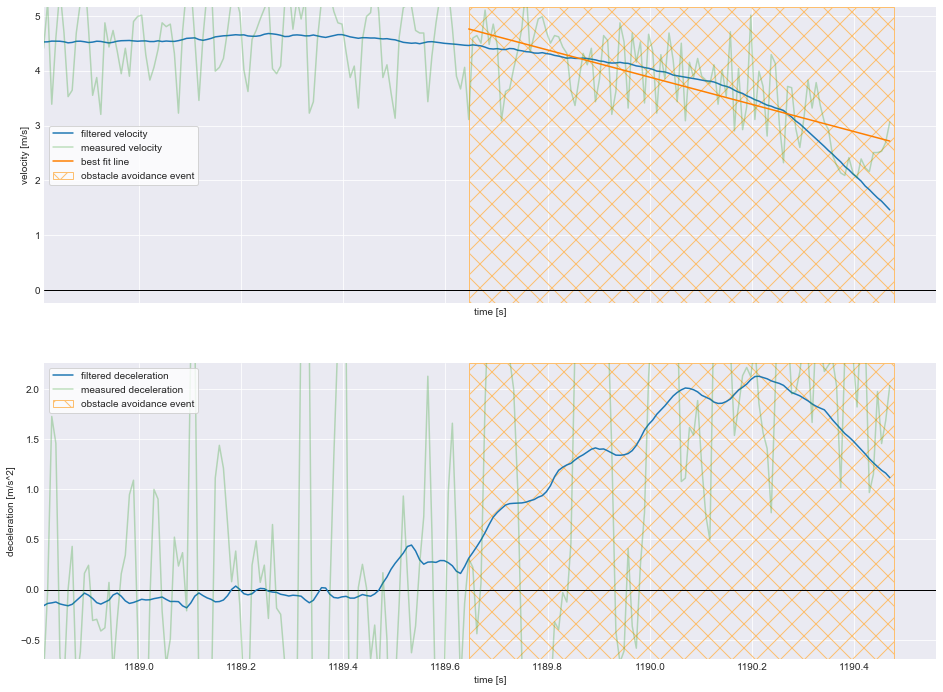

In [218]:
plt.close('all')
fig, axes = plt.subplots(2, 1, sharex=True)
braking.plot_trial_braking_event(trial.data, ax=axes[0])
braking.plot_trial_braking_event(trial.data, ax=axes[1])

# remove braking region
for i, ax in enumerate(axes):
    p = [child for child in ax.get_children()
         if isinstance(child, mpatches.Polygon)][0]
    
    p.set_fill(False)
    p.set_hatch('x')
    p.set_label('obstacle avoidance event')
    p.set_color(colors[6])
    p.set_zorder(1)
    p.set_alpha(1)
    
    # span of event
    xmin = p.xy[:, 0].min()
    xmax = p.xy[:, 0].max()

    lines = ax.get_lines()
    
    if i == 0:
        ax.set_ylabel('velocity [m/s]')

        # remove acceleration
        lines[1].remove()
        lines[3].remove()
        
        filtered = lines[0]
        measured = lines[2]
        
        # update label
        filtered.set_label('filtered velocity')
        measured.set_label('measured velocity')
        lines[5].set_label('best fit line')
    else:
        ax.set_ylabel('deceleration [m/s^2]')
        
        # remove velocity
        lines[0].remove()
        lines[2].remove()
        
        # remove best fit line
        lines[5].remove()
        
        filtered = lines[1]
        measured = lines[3]
        
        # update label
        filtered.set_label('filtered deceleration')
        measured.set_label('measured deceleration')
        
    # store y data for measured signal
    y = measured.get_ydata()
    
    # relimit based on filtered signal
    measured.set_ydata(0*y)
    ax.relim()
    ax.autoscale()
    
    # restore measured signal
    measured.set_ydata(y)
    
    filtered.set_color(colors[1])
    measured.set_color(colors[3])
        
    ax.legend()
    
# change x limits
xdelta = 0.1*(xmax - xmin)
ax.set_xlim(xmin - 10*xdelta, xmax + xdelta)

plt.show()

minima frequencies: [ 0.18395879  1.28771155  1.60963944  1.83958793]


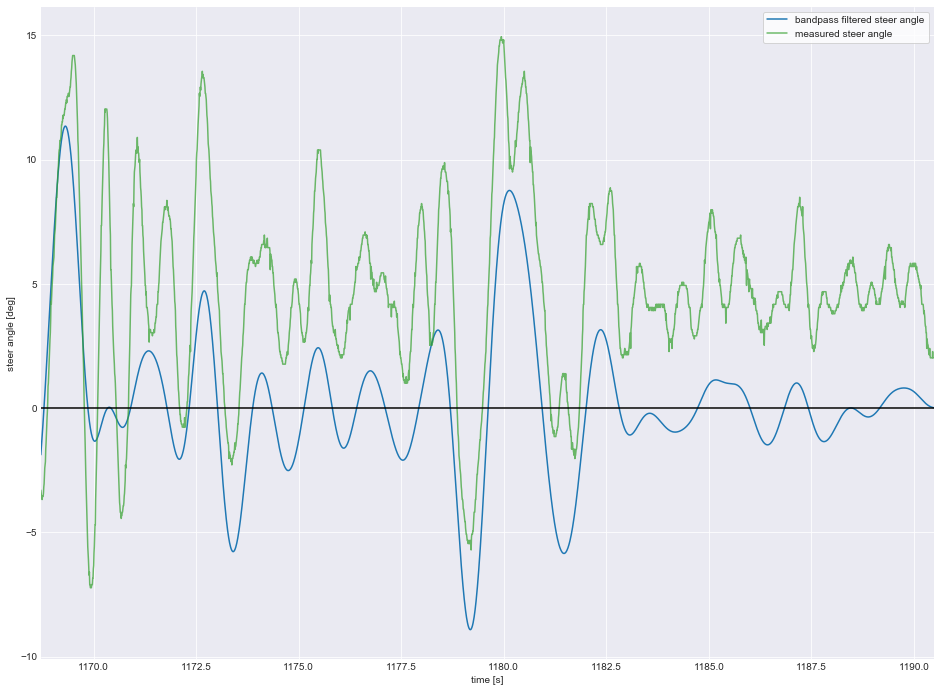

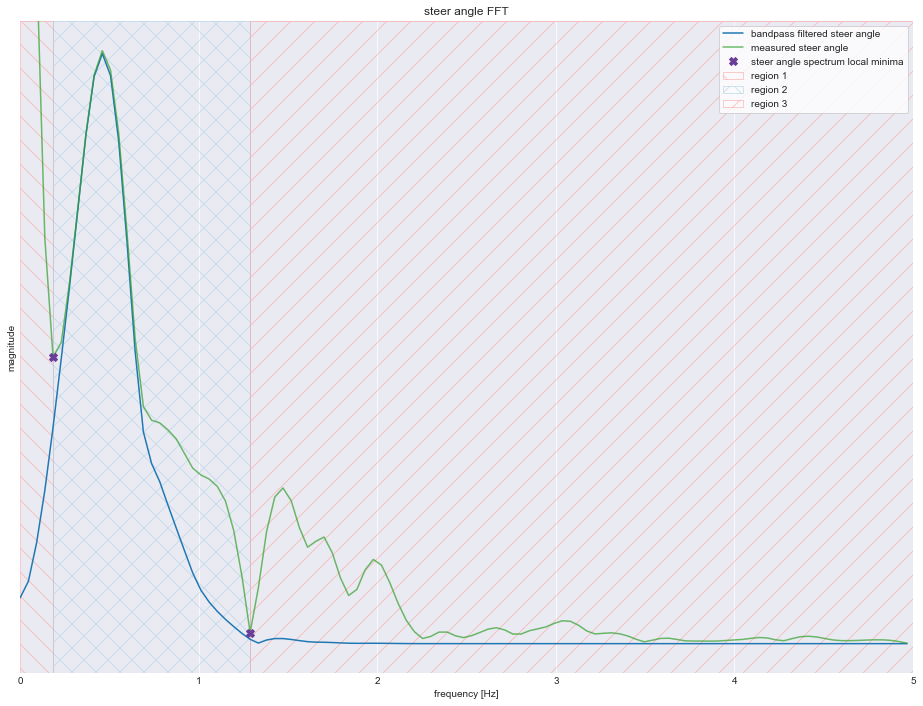

In [200]:
plt.close('all')

cutoff, (freq, xf), minima = trial.steer_angle_cutoff(True)
print('minima frequencies:', freq[minima])

axes = [plt.subplots()[1] for i in range(2)]
trial.plot_steer_angle_filter_calculation(ax=axes)

for i, l in enumerate(axes[0].get_lines()):
    if i < 3 or i > 4:
        # filtered steer angle, measured steer angle
        l.remove()
    else:
        # convert angles from radians to degrees
        ydata = l.get_ydata()
        l.set_ydata(180/np.pi*ydata)
        l.set_linestyle('-')
                
for i, l in enumerate(axes[1].get_lines()):
    if i < 3 or i > 4:
        # filtered steer angle, measured steer angle
        l.remove()
    else:
        l.set_linestyle('-')
        
lines = axes[0].get_lines()

lines[0].set_color(colors[1])
lines[0].set_label('bandpass filtered steer angle')

lines[1].set_color(colors[3])
lines[1].set_alpha(0.7)
lines[1].set_label('measured steer angle')
    
lines = axes[1].get_lines()

lines[0].set_color(colors[1])
lines[0].set_label('bandpass filtered steer angle')

lines[1].set_color(colors[3])
lines[1].set_alpha(0.7)
lines[1].set_label('measured steer angle')

axes[0].axhline(0, color='black')

axes[1].plot(freq[minima][:2], xf[minima][:2],
             'X',
             label='steer angle spectrum local minima',
             color=colors[9],
             markersize=8)

axes[1].axvspan(0, freq[minima[0]],
                label='region 1',
                hatch='\\',
                fill=False,
                alpha=0.5,
                color=colors[4])
axes[1].axvspan(freq[minima[0]], freq[minima[1]],
                label='region 2',
                hatch='X',
                fill=False,
                alpha=0.5,
                color=colors[0])
axes[1].axvspan(freq[minima[1]], 5,
                label='region 3',
                hatch='/',
                fill=False,
                alpha=0.5,
                color=colors[4])
    
axes[0].legend()
axes[1].legend()
axes[0].set_xlim((trial.data.time[0], trial.data.time[-1]))
axes[1].set_xlim((0, 5))

axes[0].set_ylabel('steer angle [deg]')

# update axes[0] y limits after conversion from rad to deg
axes[0].relim()
axes[0].autoscale_view()

# remove y ticks
axes[1].set_ylabel('magnitude')
axes[1].get_yaxis().set_ticks([])

plt.show()

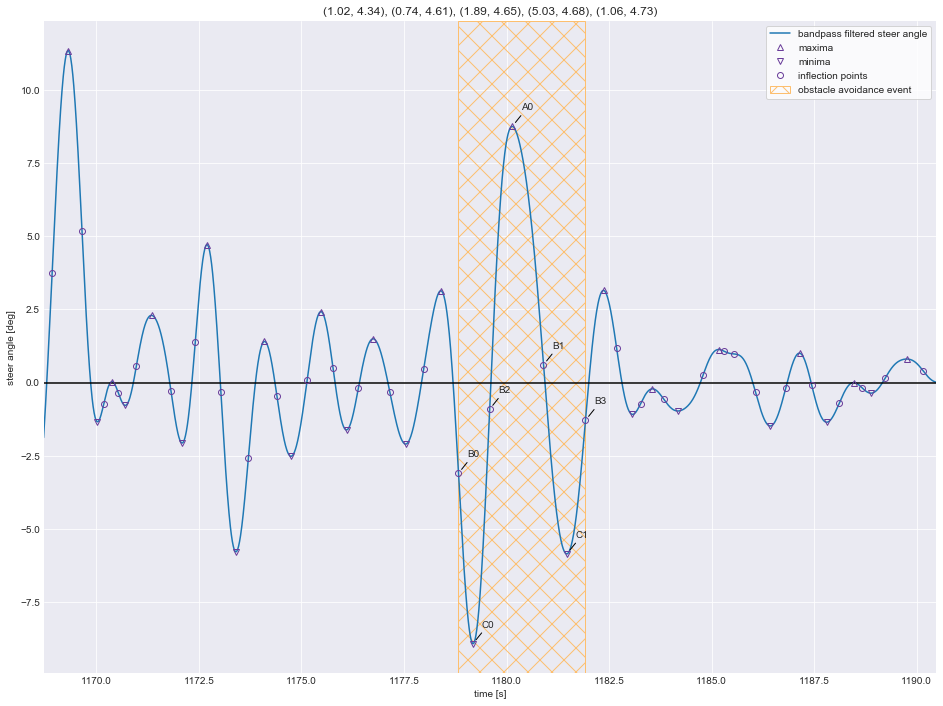

In [235]:
plt.close('all')

ax = trial.plot_steer_event_detection()

# change x limit for consistency
ax.set_xlim((trial.data.time[0], trial.data.time[-1]))

lines = ax.get_lines()

# change from radians to degrees
for l in lines[:4]:
    y = l.get_ydata()
    l.set_ydata(180/np.pi*y)
    
# update axis y limits after conversion from rad to deg
ax.relim()
ax.autoscale_view()

lines[0].set_label('bandpass filtered steer angle')
lines[0].set_color(colors[1])
lines[0].set_zorder(2)

# lines[1]: maxima
lines[1].set_marker('^')
lines[1].set_markerfacecolor('None')
lines[1].set_color(colors[9])
lines[1].set_zorder(3)

# lines[2]: minima
lines[2].set_marker('v')
lines[2].set_markerfacecolor('None')
lines[2].set_color(colors[9])
lines[2].set_zorder(3)

# lines[3]: inflection points
lines[3].set_marker('o')
lines[3].set_markerfacecolor('None')
lines[3].set_color(colors[9])
lines[3].set_zorder(3)

# lines[4]: x-axis

patches = [child for child in ax.get_children()
           if isinstance(child, mpatches.Polygon)]
for p in patches:
    if p.get_alpha() < 1.0:
        p.remove()
    else:
        p.set_fill(False)
        p.set_hatch('x')
        p.set_label('obstacle avoidance event')
        p.set_color(colors[6])
        p.set_zorder(1)
        
        # span of event
        xmin = p.xy[:, 0].min()
        xmax = p.xy[:, 0].max()
        
# pattern maxima
xy = lines[1].get_xydata()
a = xy[(xy[:, 0] >= xmin) & (xy[:, 0] <= xmax)]

# pattern minima
xy = lines[2].get_xydata()
c = xy[(xy[:, 0] >= xmin) & (xy[:, 0] <= xmax)]

# pattern inflection points
xy = lines[3].get_xydata()
b = xy[(xy[:, 0] >= xmin) & (xy[:, 0] <= xmax)]

text_offset = np.array([0.01, 0.025]) * np.squeeze(
    np.array([np.diff(ax.get_xlim()), np.diff(ax.get_ylim())]))

for data, baselabel in zip([a, b, c], ['A', 'B', 'C']):
    for i in range(data.shape[0]):
        xy = data[i, :]
        ax.annotate('{}{}'.format(baselabel, i), xy, 
                    xytext=xy + text_offset,
                   arrowprops={'arrowstyle': '-',
                               'connectionstyle': 'arc3',
                               'shrinkB': 5})
        
ax.legend()
    
ax.set_xlabel('time [s]')
ax.set_ylabel('steer angle [deg]')

plt.show()

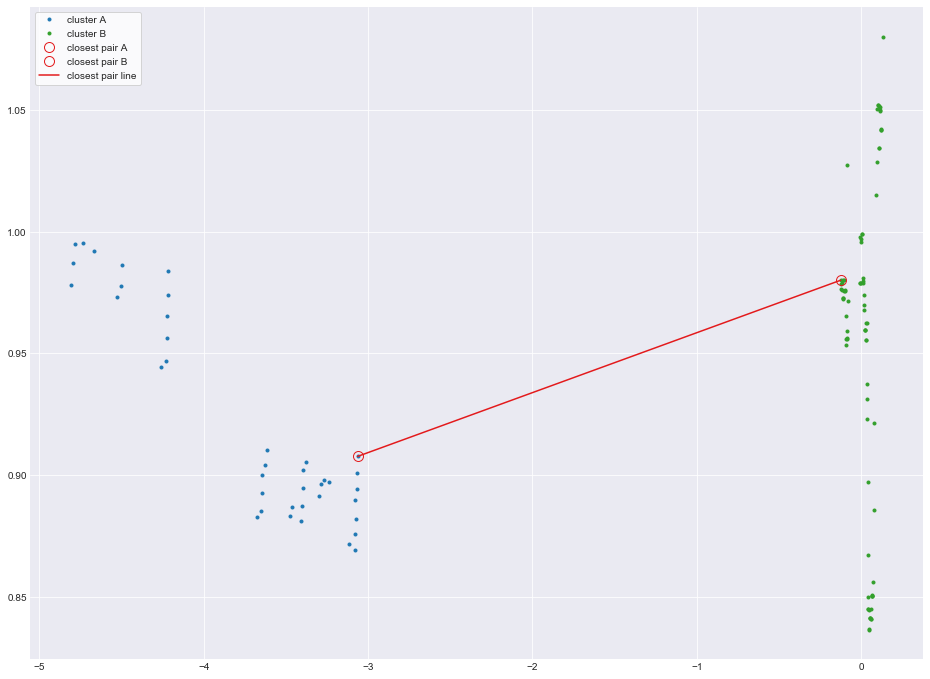

In [237]:
plt.close('all')

# get index before steer event
t0 = xmin
index = record.lidar.frame_index(t0)

x, y = record.lidar[[index]].cartesian(xlim=(-19, 1),
                                       ylim=(0.5, 3))
        
A, B = dtc.cluster(x, y)
ax, pair = dtc.plot_closest_pair(A, B)

plt.show()

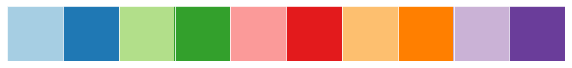

In [118]:
sns.palplot(colors)